In [6]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [1]:
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Average
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomZoom, RandomTranslation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Lambda, Flatten, Dense
from tensorflow.keras.initializers import glorot_uniform
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
K.set_image_data_format('channels_last')
import cv2
import os
from skimage import io
import numpy as np
from numpy import genfromtxt
import pandas as pd
import numpy.random as rng
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

In [2]:
"""
Utility function to load images from training dataset
"""

def loadimgs(path):
    person_dict = []
    curr = 0
    for persons in tqdm(os.listdir(path)):
        person = os.path.join(path, persons)
        imgs = []
        for face_name in os.listdir(person + '/face'):
            face_path = os.path.join(person + '/face',face_name)
            img_face = cv2.imread(face_path,-1)
            img_face = cv2.normalize(img_face, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
            img_face = cv2.resize(img_face, (128,128))
            for sign_name in os.listdir(person + '/sign'):
              sign_path = os.path.join(person + '/sign',sign_name)
              img_sign = cv2.imread(sign_path,0)
              # _,img_sign = cv2.threshold(img_sign,128,255,cv2.THRESH_OTSU)
              img_sign = cv2.normalize(img_sign, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
              img_sign = cv2.resize(img_sign, (128,128))
              img_sign = np.expand_dims(img_sign, axis=2)
              img = np.dstack([img_face, img_sign])
              # imgs.append(cv2.resize(img, (100,200)))
              imgs.append(img)
        person_dict.append(np.stack(imgs))
        curr+=1
    return np.stack(person_dict)

In [ ]:
train_imgs = loadimgs('/content/drive/MyDrive/idls_project_dataset/lfw')

100%|██████████| 64/64 [20:35<00:00, 19.30s/it]


In [ ]:
train_imgs.shape

(64, 216, 128, 128, 4)

In [ ]:
"""
 Utility function to generate a new batch
"""
def get_batch(batch_size):
    n_classes, n_examples, w, h, c = train_imgs.shape
    categories = rng.choice(n_classes,size=(batch_size,),replace=False)
    pairs=[np.zeros((batch_size, w, h, c)) for i in range(2)]
    targets=np.zeros((batch_size,))
    targets[batch_size//2:] = 1
    for i in range(batch_size):
        category = categories[i]
        idx_1 = rng.randint(0, n_examples)
        pairs[0][i,:,:,:] = train_imgs[category, idx_1].reshape(w, h, c)
        idx_2 = rng.randint(0, n_examples)
        
        # pick images of same class for 1st half, different for 2nd
        if i >= batch_size // 2:
            category_2 = category  
        else: 
            # add a random number to the category modulo n classes to ensure 2nd image has a different category
            category_2 = (category + rng.randint(1,n_classes)) % n_classes
        
        pairs[1][i,:,:,:] = train_imgs[category_2,idx_2].reshape(w, h, c)
    
    return pairs, targets

def generate(batch_size):
    while True:
        pairs, targets = get_batch(batch_size)
        yield (pairs, targets)

In [3]:
def get_siamese_model(input_shape):
    """
        Model architecture
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)

    # Data augmentation
    data_augmentation = Sequential([
      RandomFlip("horizontal"),
      RandomRotation(0.2),
      RandomContrast(0.2),
      RandomZoom(.2, .2)
    ])
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(data_augmentation)
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,
                  kernel_initializer='random_uniform', kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())

    model.add(Conv2D(128, (7,7), activation='relu',
                    kernel_initializer='random_uniform',
                    bias_initializer='random_uniform', kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())

    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer='random_uniform',
                    bias_initializer='random_uniform', kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())

    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer='random_uniform',
                    bias_initializer='random_uniform', kernel_regularizer=l2(2e-4)))
    model.add(Flatten())

    model.add(Dense(4096, activation='relu',
                  kernel_regularizer=l2(1e-3),
                  kernel_initializer='random_uniform',bias_initializer='random_uniform'))

    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
      
    # Add a customized layer to compute the absolute difference between the encodings
    
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
      

    penultimate_1 = Dense(512,activation='relu',bias_initializer='random_uniform')(L1_distance)
    prediction = Dense(1,activation='sigmoid',bias_initializer='random_uniform')(penultimate_1)

    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [4]:
model = get_siamese_model((128, 128, 4))
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 4  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 4  0           []                               
                                )]                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 4096)         68326976    ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

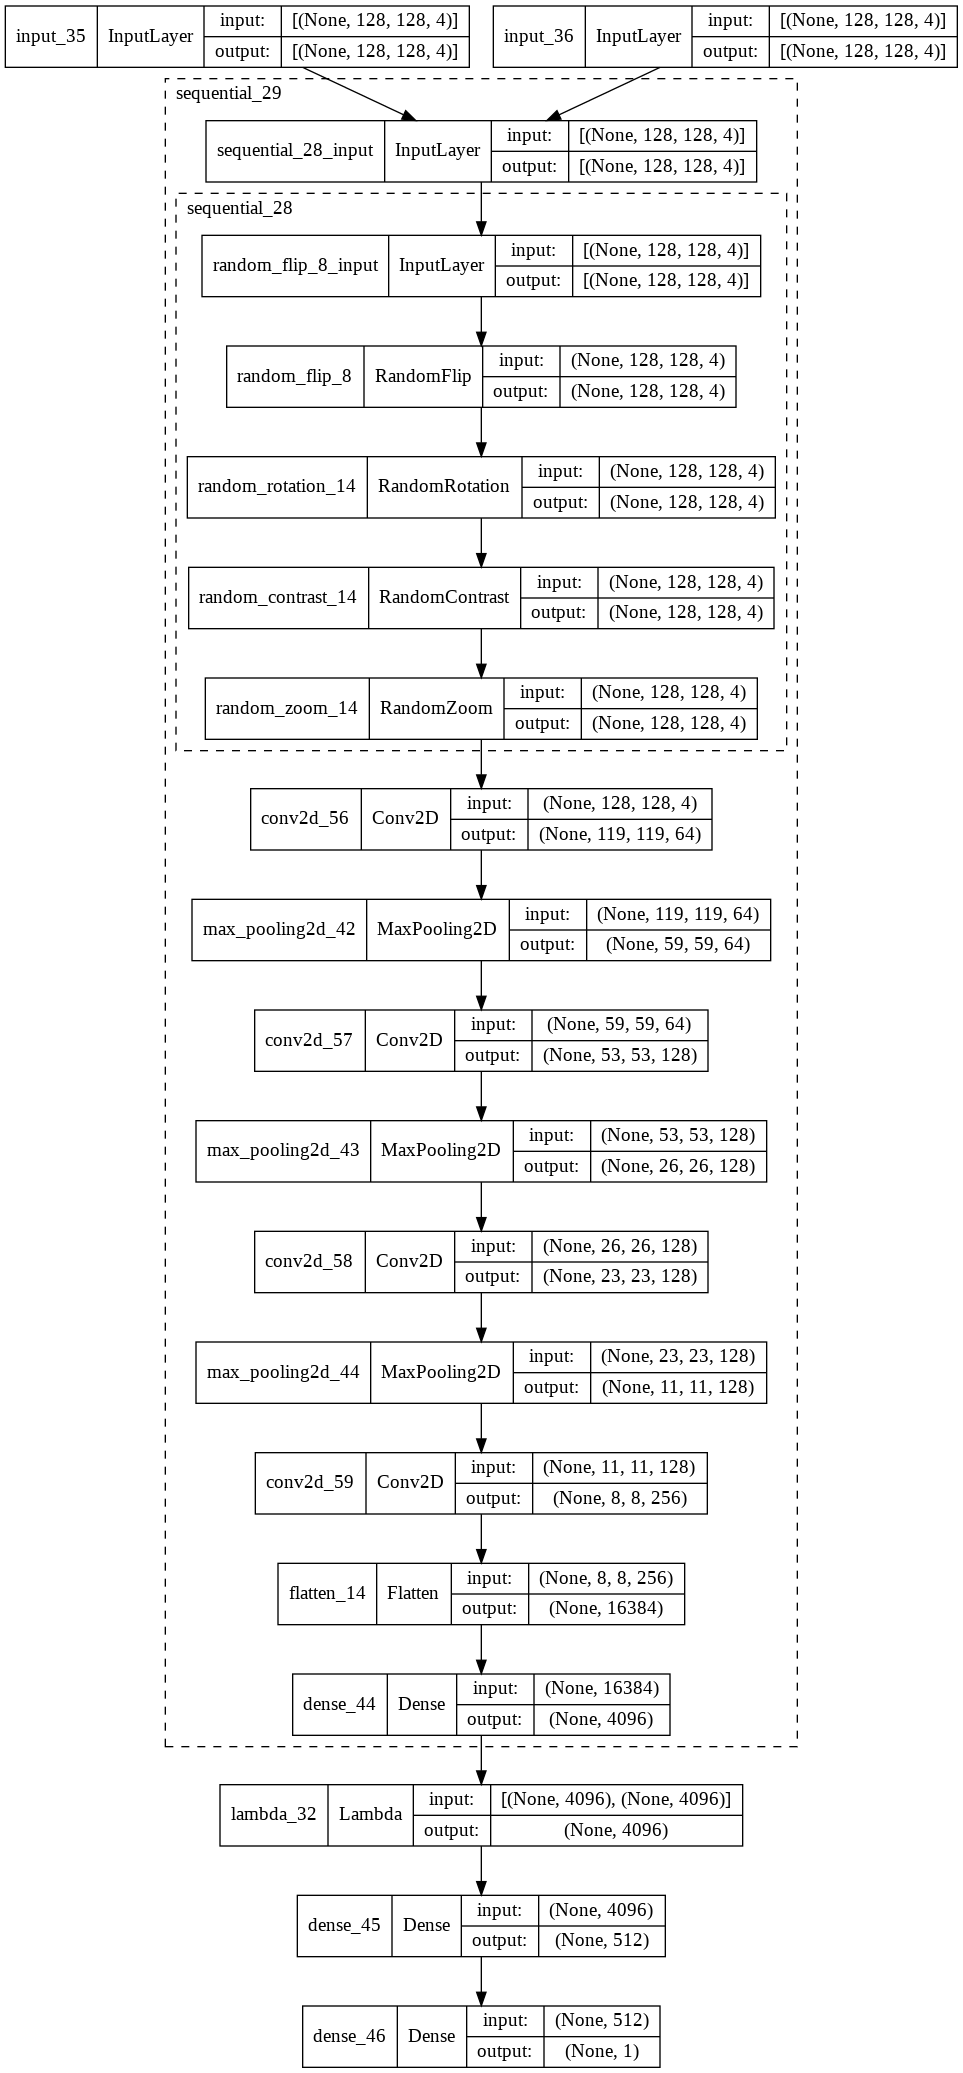

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

In [ ]:
loss_every = 20 # interval for printing loss (iterations)
evaluate_every = 1000
batch_size = 64
n_iter = 10000
N_way = 20 # how many classes for testing one-shot tasks>
n_val = 250 # how many one-shot tasks to validate on?
best = -1

In [ ]:
optimizer = Adam(learning_rate = 0.0001)
model.compile(loss="binary_crossentropy",optimizer=optimizer)

In [ ]:
"""
Function to generate a new N-way oneshot task
"""

def make_oneshot_task(N,s="val"):
    n_classes, n_examples, w, h, c = train_imgs.shape
    indices = rng.randint(0,n_examples,size=(N,))

    # Sample random classes
    categories = rng.choice(range(n_classes),size=(N,),replace=False)

    # Make first one as anchor
    true_category = categories[0]
    ex1, ex2 = rng.choice(n_examples,replace=False,size=(2,))
    test_image = np.asarray([train_imgs[true_category,ex1,:,:]]*N).reshape(N, w, h, c)

    # Sample randomly for the otehr images
    support_set = train_imgs[categories,indices,:,:]
    support_set[0,:,:] = train_imgs[true_category,ex2]
    support_set = support_set.reshape(N, w, h, c)
    targets = np.zeros((N,))
    targets[0] = 1
    targets, test_image, support_set = shuffle(targets, test_image, support_set)
    pairs = [test_image,support_set]

    return pairs, targets

In [ ]:
def test_oneshot(model,N,k):
    """Test average N way oneshot learning accuracy of a siamese neural net over k one-shot tasks"""
    n_correct = 0
    print("Evaluating model on {} random {} way one-shot learning tasks ... \n".format(k,N))
    for i in range(k):
        inputs, targets = make_oneshot_task(N)
        probs = model.predict(inputs)
        if np.argmax(probs) == np.argmax(targets):
            n_correct+=1
    percent_correct = (100.0*n_correct / k)
    print("Got an average of {}% {} way one-shot learning accuracy \n".format(percent_correct,N))
    return percent_correct
  
def train(model, epochs):
    model.fit_generator(self.generate(batch_size))

In [ ]:
print("Starting training process!")
print("-------------------------------------")
iters = []
losses = []
t_start = time.time()
for i in range(1, n_iter):
    (inputs,targets)=get_batch(batch_size)
    loss=model.train_on_batch(inputs,targets)
    print("\n ------------- \n")
    print("Loss: {0}".format(loss)) 
    if i % evaluate_every == 0:
        print("Time for {0} iterations: {1}".format(i, time.time()-t_start))
        val_acc = test_oneshot(model,N_way,n_val)
        if val_acc >= best:
            print("Current best: {0}, previous best: {1}".format(val_acc, best))
            print("Saving weights")
            model.save_weights('/content/drive/MyDrive/idls_project_dataset/Weights/model_weights.h5')
            best=val_acc
    
    if i % loss_every == 0:
        print("iteration {}, training loss: {:.2f},".format(i,loss))
        iters.append(i)
        losses.append(loss)

Streaming output truncated to the last 5000 lines.

 ------------- 

Loss: 0.34952038526535034

 ------------- 

Loss: 0.4074249565601349

 ------------- 

Loss: 0.3215887248516083

 ------------- 

Loss: 0.42296820878982544

 ------------- 

Loss: 0.30910447239875793

 ------------- 

Loss: 0.3672406077384949

 ------------- 

Loss: 0.44998446106910706

 ------------- 

Loss: 0.31755849719047546

 ------------- 

Loss: 0.3881187438964844

 ------------- 

Loss: 0.35175713896751404

 ------------- 

Loss: 0.4627753496170044

 ------------- 

Loss: 0.4201722741127014

 ------------- 

Loss: 0.3503294289112091

 ------------- 

Loss: 0.3372489809989929
iteration 8780, training loss: 0.34,

 ------------- 

Loss: 0.4559353291988373

 ------------- 

Loss: 0.3169947564601898

 ------------- 

Loss: 0.33759498596191406

 ------------- 

Loss: 0.40484336018562317

 ------------- 

Loss: 0.42934319376945496

 ------------- 

Loss: 0.3207973837852478

 ------------- 

Loss: 0.3618873655796051


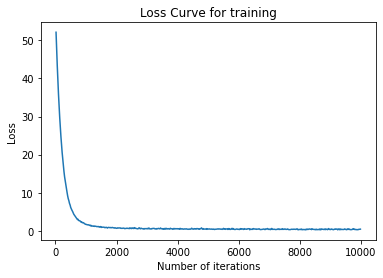

In [ ]:
plt.plot(iters, losses)
plt.xlabel("Number of iterations")
plt.ylabel("Loss")
plt.title("Loss Curve for training")
plt.show()

In [7]:
model.load_weights('/content/drive/MyDrive/idls_project_dataset/Weights/model_weights_final.h5')

In [ ]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0


def test_nn_accuracy(N_ways,n_trials):
    """Returns accuracy of one shot """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        pairs,targets = make_oneshot_task(N_ways)
        correct = nearest_neighbour_correct(pairs,targets)
        n_right += correct
    return 100.0 * n_right / n_trials


ways = np.arange(1, 21, 1)
resume =  False
val_accs, train_accs,nn_accs = [], [], []
trials = 450
for N in ways:
    val_accs.append(test_oneshot(model, N,trials))
    nn_accs.append(test_nn_accuracy(N,trials))

Evaluating model on 450 random 1 way one-shot learning tasks ... 

Got an average of 100.0% 1 way one-shot learning accuracy 

Evaluating nearest neighbour on 450 unique 1 way one-shot learning tasks ...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in sqrt
  


Evaluating model on 450 random 2 way one-shot learning tasks ... 

Got an average of 98.66666666666667% 2 way one-shot learning accuracy 

Evaluating nearest neighbour on 450 unique 2 way one-shot learning tasks ...
Evaluating model on 450 random 3 way one-shot learning tasks ... 

Got an average of 94.22222222222223% 3 way one-shot learning accuracy 

Evaluating nearest neighbour on 450 unique 3 way one-shot learning tasks ...
Evaluating model on 450 random 4 way one-shot learning tasks ... 

Got an average of 91.77777777777777% 4 way one-shot learning accuracy 

Evaluating nearest neighbour on 450 unique 4 way one-shot learning tasks ...
Evaluating model on 450 random 5 way one-shot learning tasks ... 

Got an average of 90.66666666666667% 5 way one-shot learning accuracy 

Evaluating nearest neighbour on 450 unique 5 way one-shot learning tasks ...
Evaluating model on 450 random 6 way one-shot learning tasks ... 

Got an average of 88.66666666666667% 6 way one-shot learning accuracy

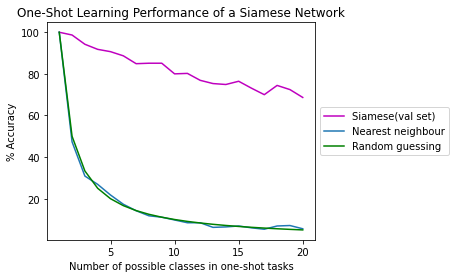

In [ ]:
fig,ax = plt.subplots(1)
ax.plot(ways, val_accs, "m", label="Siamese(val set)")
plt.plot(ways, nn_accs, label="Nearest neighbour")

ax.plot(ways, 100.0/ways, "g", label="Random guessing")
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.title("One-Shot Learning Performance of a Siamese Network")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


In [8]:
"""
Preprocess images to make them compatible with the format the model expects them to be in.
"""

def preprocess_imgs(face_img, sign_img):
  face_img = cv2.normalize(face_img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  face_img = cv2.resize(face_img, (128,128))
  sign_img = cv2.normalize(sign_img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
  sign_img = cv2.resize(sign_img, (128,128))
  sign_img = np.expand_dims(sign_img, axis=2)
  img = np.dstack([face_img, sign_img])


  img = np.expand_dims(img, axis=0)
  return img

In [9]:
face_img1 = cv2.imread('/content/drive/MyDrive/idls_project_dataset/custom/face1.jpg',-1)
sign_img1 = cv2.imread('/content/drive/MyDrive/idls_project_dataset/custom/sign1.jpg',0)

face_img2 = cv2.imread('/content/drive/MyDrive/idls_project_dataset/custom/face2.jpg',-1)
sign_img2 = cv2.imread('/content/drive/MyDrive/idls_project_dataset/custom/sign2.jpg',0)

face_img3 = cv2.imread('/content/drive/MyDrive/idls_project_dataset/custom/face3.jpg',-1)
sign_img3 = cv2.imread('/content/drive/MyDrive/idls_project_dataset/custom/sign3.jpg',0)

face_img4 = cv2.imread('/content/drive/MyDrive/idls_project_dataset/custom/face4.jpg',-1)
sign_img4 = cv2.imread('/content/drive/MyDrive/idls_project_dataset/custom/sign4.jpg',0)

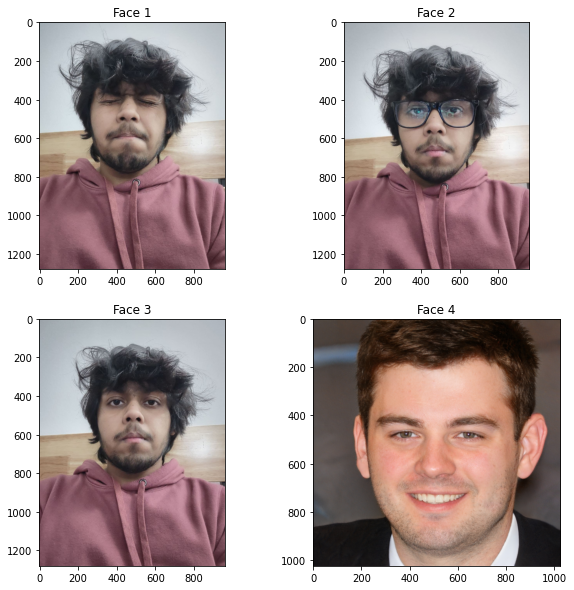

In [10]:
fig = plt.figure(figsize=(10, 10))
columns = 2
rows = 2
ax = fig.add_subplot(2, 2, 1)
ax.title.set_text('Face 1')
plt.imshow(cv2.cvtColor(face_img1, cv2.COLOR_BGR2RGB))
ax = fig.add_subplot(2, 2, 2)
ax.title.set_text('Face 2')
plt.imshow(cv2.cvtColor(face_img2, cv2.COLOR_BGR2RGB))
ax = fig.add_subplot(2, 2, 3)
ax.title.set_text('Face 3')
plt.imshow(cv2.cvtColor(face_img3, cv2.COLOR_BGR2RGB))
ax = fig.add_subplot(2, 2, 4)
ax.title.set_text('Face 4')
plt.imshow(cv2.cvtColor(face_img4, cv2.COLOR_BGR2RGB))
plt.show()

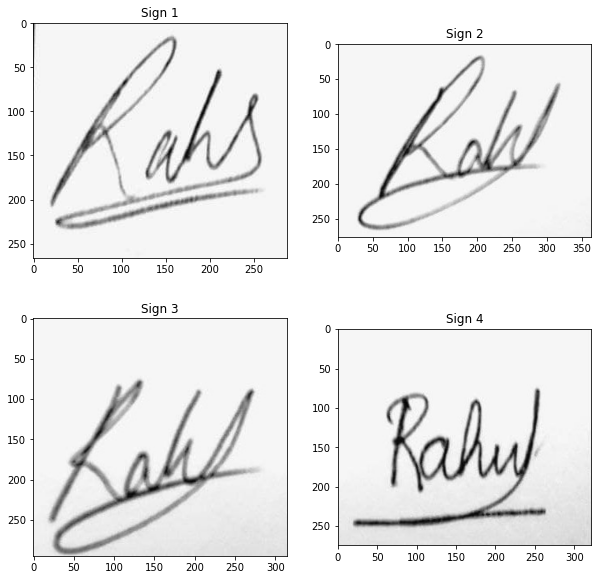

In [11]:
fig = plt.figure(figsize=(10, 10))
columns = 2
rows = 2
ax = fig.add_subplot(2, 2, 1)
ax.title.set_text('Sign 1')
plt.imshow(cv2.cvtColor(sign_img1, cv2.COLOR_BGR2RGB))
ax = fig.add_subplot(2, 2, 2)
ax.title.set_text('Sign 2')
plt.imshow(cv2.cvtColor(sign_img2, cv2.COLOR_BGR2RGB))
ax = fig.add_subplot(2, 2, 3)
ax.title.set_text('Sign 3')
plt.imshow(cv2.cvtColor(sign_img3, cv2.COLOR_BGR2RGB))
ax = fig.add_subplot(2, 2, 4)
ax.title.set_text('Sign 4')
plt.imshow(cv2.cvtColor(sign_img4, cv2.COLOR_BGR2RGB))
plt.show()

### Same signature, different faces

In [12]:
model.predict([preprocess_imgs(face_img1, sign_img1), preprocess_imgs(face_img1, sign_img1)])

array([[0.95787656]], dtype=float32)

In [13]:
model.predict([preprocess_imgs(face_img1, sign_img1), preprocess_imgs(face_img2, sign_img1)])

array([[0.957507]], dtype=float32)

In [14]:
model.predict([preprocess_imgs(face_img1, sign_img1), preprocess_imgs(face_img3, sign_img1)])

array([[0.97175914]], dtype=float32)

In [15]:
model.predict([preprocess_imgs(face_img1, sign_img1), preprocess_imgs(face_img4, sign_img1)])

array([[0.21010171]], dtype=float32)

In [16]:
model.predict([preprocess_imgs(face_img2, sign_img1), preprocess_imgs(face_img3, sign_img1)])

array([[0.9663173]], dtype=float32)

In [17]:
model.predict([preprocess_imgs(face_img4, sign_img1), preprocess_imgs(face_img3, sign_img1)])

array([[0.23966846]], dtype=float32)

### Same faces, different signatures

In [18]:
model.predict([preprocess_imgs(face_img1, sign_img1), preprocess_imgs(face_img1, sign_img2)])

array([[0.70769167]], dtype=float32)

In [19]:
model.predict([preprocess_imgs(face_img1, sign_img1), preprocess_imgs(face_img1, sign_img3)])

array([[0.6908207]], dtype=float32)

In [20]:
model.predict([preprocess_imgs(face_img1, sign_img1), preprocess_imgs(face_img1, sign_img4)])

array([[0.48150596]], dtype=float32)

In [21]:
model.predict([preprocess_imgs(face_img2, sign_img1), preprocess_imgs(face_img2, sign_img3)])

array([[0.5942739]], dtype=float32)

In [22]:
model.predict([preprocess_imgs(face_img3, sign_img2), preprocess_imgs(face_img3, sign_img3)])

array([[0.7672529]], dtype=float32)

In [23]:
model.predict([preprocess_imgs(face_img2, sign_img2), preprocess_imgs(face_img2, sign_img4)])

array([[0.22179411]], dtype=float32)

### Different faces, different signatures

In [24]:
model.predict([preprocess_imgs(face_img1, sign_img1), preprocess_imgs(face_img2, sign_img2)])

array([[0.62847465]], dtype=float32)

In [25]:
model.predict([preprocess_imgs(face_img3, sign_img1), preprocess_imgs(face_img2, sign_img3)])

array([[0.820359]], dtype=float32)

In [26]:
model.predict([preprocess_imgs(face_img4, sign_img1), preprocess_imgs(face_img2, sign_img3)])

array([[0.04849896]], dtype=float32)

In [27]:
model.predict([preprocess_imgs(face_img4, sign_img1), preprocess_imgs(face_img3, sign_img2)])

array([[0.03616473]], dtype=float32)

In [28]:
model.predict([preprocess_imgs(face_img1, sign_img1), preprocess_imgs(face_img3, sign_img4)])

array([[0.39558822]], dtype=float32)

In [29]:
model.predict([preprocess_imgs(face_img2, sign_img1), preprocess_imgs(face_img4, sign_img4)])

array([[0.04986642]], dtype=float32)